# MNIST distributed training with TensorFlow  

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
1. [Predict](#Predict)


## Background

The **SageMaker Python SDK** helps you deploy your models for training and hosting in optimized, productions ready containers in SageMaker. The SageMaker Python SDK is easy to use, modular, extensible and compatible with TensorFlow and MXNet. This tutorial focuses on how to create a convolutional neural network model to train the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) using **TensorFlow distributed training**.




## Setup

Here we will start by importing the necessary libraries for this notebook.

In [1]:
import os
os.system("aws s3 cp s3://sagemaker-workshop-pdx/mnist/utils.py utils.py")
os.system("aws s3 cp s3://sagemaker-workshop-pdx/mnist/mnist.py mnist.py")
import sagemaker
import utils
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib.learn.python.learn.datasets import mnist
import tensorflow as tf
import boto3
import warnings; warnings.simplefilter('ignore')

Next we specify the IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `get_execution_role()` call with the appropriate full IAM role arn string(s).

In [2]:
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()


## Data


### Download the MNIST dataset

First we will download the data from the workshop's S3 bucket, then we will extract the images from the compressed files.

In [3]:
os.system("aws s3 cp --recursive s3://sagemaker-workshop-pdx/mnist/data data")

data_sets = mnist.read_data_sets('mnist/data', dtype=tf.uint8, reshape=False, validation_size=5000)

utils.convert_to(data_sets.train, 'train', 'mnist/data')
utils.convert_to(data_sets.validation, 'validation', 'mnist/data')
utils.convert_to(data_sets.test, 'test', 'mnist/data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Instructions for updating:
Please use tf.data to implement this functionality.


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist/data/train-images-idx3-ubyte.gz


Instructions for updating:
Please use tf.data to implement this functionality.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist/data/train-labels-idx1-ubyte.gz


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/data/t10k-labels-idx1-ubyte.gz
Writing mnist/data/train.tfrecords
Writing mnist/data/validation.tfrecords
Writing mnist/data/test.tfrecords


### Some sample images from the MNIST data set

Here are some images from the MNIST traing data set, feel free to change the batch number and re-run this cell to see some other images from the collection, or, change the data set it pulls from to the test data set to see images from that collection.

In [4]:
!cat utils.py

"""Converts MNIST data to TFRecords file format with Example protos."""
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def convert_to(data_set, name, directory):
    """Converts a dataset to tfrecords."""
    images = data_set.images
    labels = data_set.labels
    num_examples = data_set.num_examples

    if images.shape[0] != num_examples:
        raise ValueError('Images size %d does not match label size %d.' %
                         (images.shape[0], num_examples))
    rows = images.shape[1]
    cols = images.shape[2]
    depth = images.shape[3]

    filename = os.path.join(directory, name + '.tfrecords')
    print('Writing', filename)
    writer = tf.python_io.TFRecordWriter(filename)
    for index in range(num_examples):
        image_

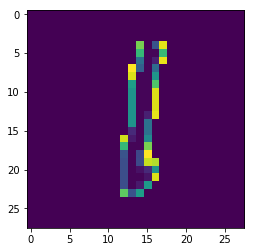

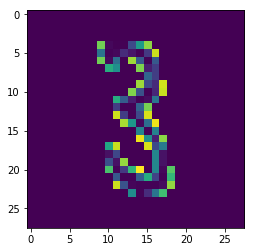

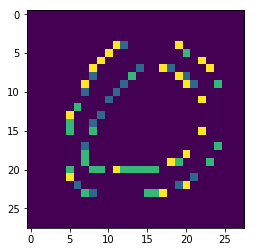

In [5]:
batch_xs, batch_ys = data_sets.train.next_batch(5) # Change "train" to "test" or select a different batch.
utils.gen_image(batch_xs[0]).show()
utils.gen_image(batch_xs[1]).show()
utils.gen_image(batch_xs[2]).show()

### Upload the data
We use the ```sagemaker.Session.upload_data``` function to upload our datasets to an S3 bucket. The return value of inputs identifies the location -- we will use this later when we start the training job.

In [6]:
inputs = sagemaker_session.upload_data(path='mnist/data', key_prefix='data/mnist')


## Train

Here is the full code for the network model:

In [7]:
!cat 'mnist.py'

import os
import tensorflow as tf
from tensorflow.python.estimator.model_fn import ModeKeys as Modes

INPUT_TENSOR_NAME = 'inputs'
SIGNATURE_NAME = 'predictions'

LEARNING_RATE = 0.001


def model_fn(features, labels, mode, params):
    # Input Layer
    input_layer = tf.reshape(features[INPUT_TENSOR_NAME], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.d

The script here is an adaptation of the [TensorFlow MNIST example](https://github.com/tensorflow/models/tree/master/official/mnist). We have defined ```model_fn(features, labels, mode)```, which includes all the logic to support training, evaluation and inference. 

### A regular ```model_fn```

A regular **```model_fn```** follows the pattern:
1. [defines a neural network](https://github.com/tensorflow/models/blob/master/official/mnist/mnist.py#L96)
- [applies the ```features``` in the neural network](https://github.com/tensorflow/models/blob/master/official/mnist/mnist.py#L178)
- [if the ```mode``` is ```PREDICT```, returns the output from the neural network](https://github.com/tensorflow/models/blob/master/official/mnist/mnist.py#L186)
- [calculates the loss function comparing the output with the ```labels```](https://github.com/tensorflow/models/blob/master/official/mnist/mnist.py#L188)
- [creates an optimizer and minimizes the loss function to improve the neural network](https://github.com/tensorflow/models/blob/master/official/mnist/mnist.py#L193)
- [returns the output, optimizer and loss function](https://github.com/tensorflow/models/blob/master/official/mnist/mnist.py#L205)

### Writing a ```model_fn``` for distributed training
When distributed training happens, the same neural network will be sent to multiple training instances. Each instance will train with a batch of the dataset, calculate loss and minimize the optimizer. One entire loop of this process is called a **training step**.

### Syncronizing training steps
A [global step](https://www.tensorflow.org/api_docs/python/tf/train/global_step) is a global counter shared between the instances. This counter is used by the optimizer to keep track of the number of **training steps** across instances and is necessary for distributed training: 

```python
train_op = optimizer.minimize(loss, tf.train.get_or_create_global_step())
```

That is also the **only** required change for distributed training!

### Create a training job using the sagemaker.TensorFlow estimator

In [8]:
from sagemaker.tensorflow import TensorFlow

mnist_estimator = TensorFlow(entry_point='mnist.py',
                             role=role,
                             training_steps=1000, 
                             evaluation_steps=100,
                             train_instance_count=2,
                             train_instance_type='ml.c4.8xlarge')

mnist_estimator.fit(inputs)

INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-2018-08-06-19-28-38-601


.................
2018-08-06 19:31:11,398 INFO - root - running container entrypoint
2018-08-06 19:31:11,398 INFO - root - starting train task
2018-08-06 19:31:11,404 INFO - container_support.training - Training starting
2018-08-06 19:31:13,839 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTP connection (1): 169.254.170.2
2018-08-06 19:31:14,091 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): sagemaker-us-west-2-500842391574.s3.amazonaws.com
2018-08-06 19:31:14,121 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (2): sagemaker-us-west-2-500842391574.s3.amazonaws.com
2018-08-06 19:31:14,133 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): sagemaker-us-west-2-500842391574.s3.us-west-2.amazonaws.com
2018-08-06 19:31:14,198 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starti

2018-08-06 19:31:24.556649: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:31:24.563496: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:31:24.574020: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:31:24.588071: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:31:24.602971: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:31:24.610562: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:31:24.620077: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:31:24.626264: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:31:24,659 INFO - tensorflow - Call

2018-08-06 19:31:37,075 INFO - tensorflow - global_step/sec: 19.502
2018-08-06 19:31:41,736 INFO - tensorflow - loss = 0.012871624, step = 279 (9.992 sec)
2018-08-06 19:31:42,202 INFO - tensorflow - global_step/sec: 19.8933
2018-08-06 19:31:43,835 INFO - tensorflow - loss = 0.052729886, step = 322 (10.330 sec)
2018-08-06 19:31:47,143 INFO - tensorflow - global_step/sec: 20.2392
2018-08-06 19:31:51,180 INFO - tensorflow - loss = 0.030013792, step = 471 (9.443 sec)
2018-08-06 19:31:52,145 INFO - tensorflow - global_step/sec: 20.1922
2018-08-06 19:31:54,189 INFO - tensorflow - loss = 0.0373847, step = 532 (10.354 sec)
2018-08-06 19:31:57,117 INFO - tensorflow - global_step/sec: 20.316
2018-08-06 19:32:00,516 INFO - tensorflow - loss = 0.038077734, step = 659 (9.336 sec)
2018-08-06 19:32:02,171 INFO - tensorflow - global_step/sec: 19.9844
2018-08-06 19:32:04,825 INFO - tensorflow - loss = 0.06467671, step = 746 (10.636 sec)
2018-08-06 19:32:07,145 INFO - tensorflow - global_step/sec: 20.30

2018-08-06 19:32:26.600164: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:32:26.609398: I tensorflow/core/platform/s3/aws_logging.cc:54] Deleting file: /tmp/s3_filesystem_XXXXXX20180806T1932261533583946600
2018-08-06 19:32:26.609595: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:32:26.617142: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:32:26.626243: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:32:26.636599: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:32:26.644933: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:32:26.656939: I tensorflow/core/platform/s3/aws_logging.cc:54] Connection has been released. Continuing.
2018-08-06 19:32:26.6

The **```fit```** method will create a training job using two **ml.c4.8xlarge** instances. The output above will show the status of the training jobs on each instance during training and evaluation.

When training is complete, the training job will generate a saved model for serving using a SageMaker endpoint.


## Host


### Deploy the trained model to prepare for predictions

The deploy() method creates a SageMaker endpoint which serves prediction requests in real-time.

In [9]:
mnist_predictor = mnist_estimator.deploy(initial_instance_count=1,
                                             instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-2018-08-06-19-28-38-601
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-2018-08-06-19-28-38-601


--------------------------------------------------------------!


## Predict

### Invoking the endpoint

Now we will pass some of the test images to the model endpoint for inference.

Extracting /tmp/data/train-images-idx3-ubyte.gz


Instructions for updating:
Please use tf.one_hot on tensors.


Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


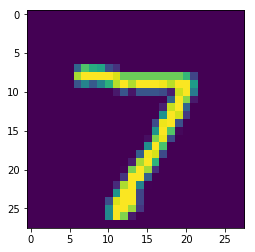

Label is: 7
Prediction is: 7
_________________________________


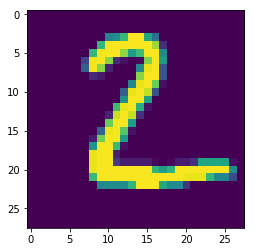

Label is: 2
Prediction is: 2
_________________________________


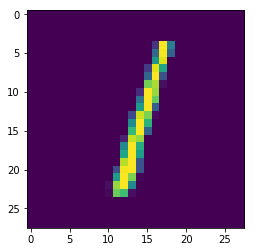

Label is: 1
Prediction is: 1
_________________________________


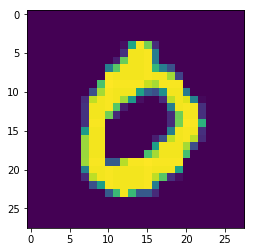

Label is: 0
Prediction is: 0
_________________________________


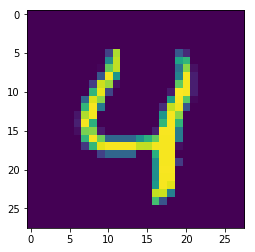

Label is: 4
Prediction is: 4
_________________________________


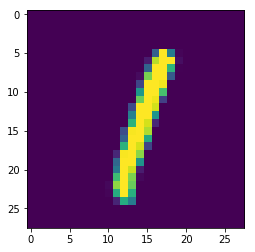

Label is: 1
Prediction is: 1
_________________________________


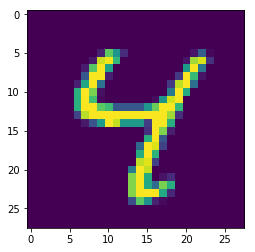

Label is: 4
Prediction is: 4
_________________________________


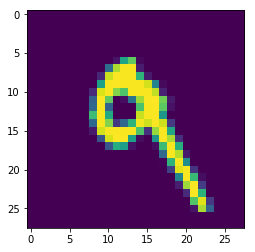

Label is: 9
Prediction is: 9
_________________________________


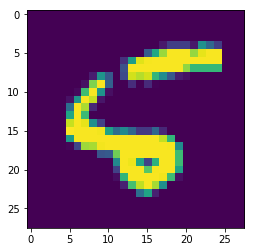

Label is: 5
Prediction is: 5
_________________________________


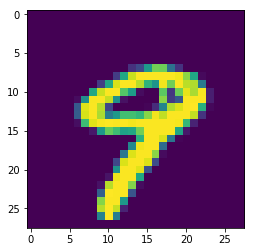

Label is: 9
Prediction is: 9
_________________________________


In [10]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

for i in range(10):
    data = mnist.test.images[i].tolist()
    tensor_proto = tf.make_tensor_proto(values=np.asarray(data), shape=[1, len(data)], dtype=tf.float32)
    predict_response = mnist_predictor.predict(tensor_proto)
    
    image = mnist.test.images[i]
    image = np.array(image, dtype='float')
    plt.imshow(image.reshape(28, 28))
    plt.show()
    label = np.argmax(mnist.test.labels[i])
    print("Label is: {}".format(label))
    prediction = predict_response['outputs']['classes']['int64_val'][0]
    print("Prediction is: {}".format(prediction))
    print("_________________________________")

# Deleting the endpoint
When you are done with the notebook, delete the endpoint to not incur unneccessary charges by running the following cell.

In [ ]:
sagemaker.Session().delete_endpoint(mnist_predictor.endpoint)